In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

summary = pd.read_excel("player_multiseason_summary_with_predictions.xlsx")
season_counts = pd.read_excel("player_season_counts.xlsx")

# Keep only players with 3+ seasons
players_3plus = season_counts[season_counts["n_seasons"] >= 3]["player"]
df = summary[summary["player"].isin(players_3plus)].copy()

df = df.sort_values(["player", "season"])

# Lagged features
df["prev_gp"] = df.groupby("player")["gp"].shift(1)
df["prev_games_missed"] = df.groupby("player")["games_missed"].shift(1)

df = df.dropna(subset=["prev_gp"])

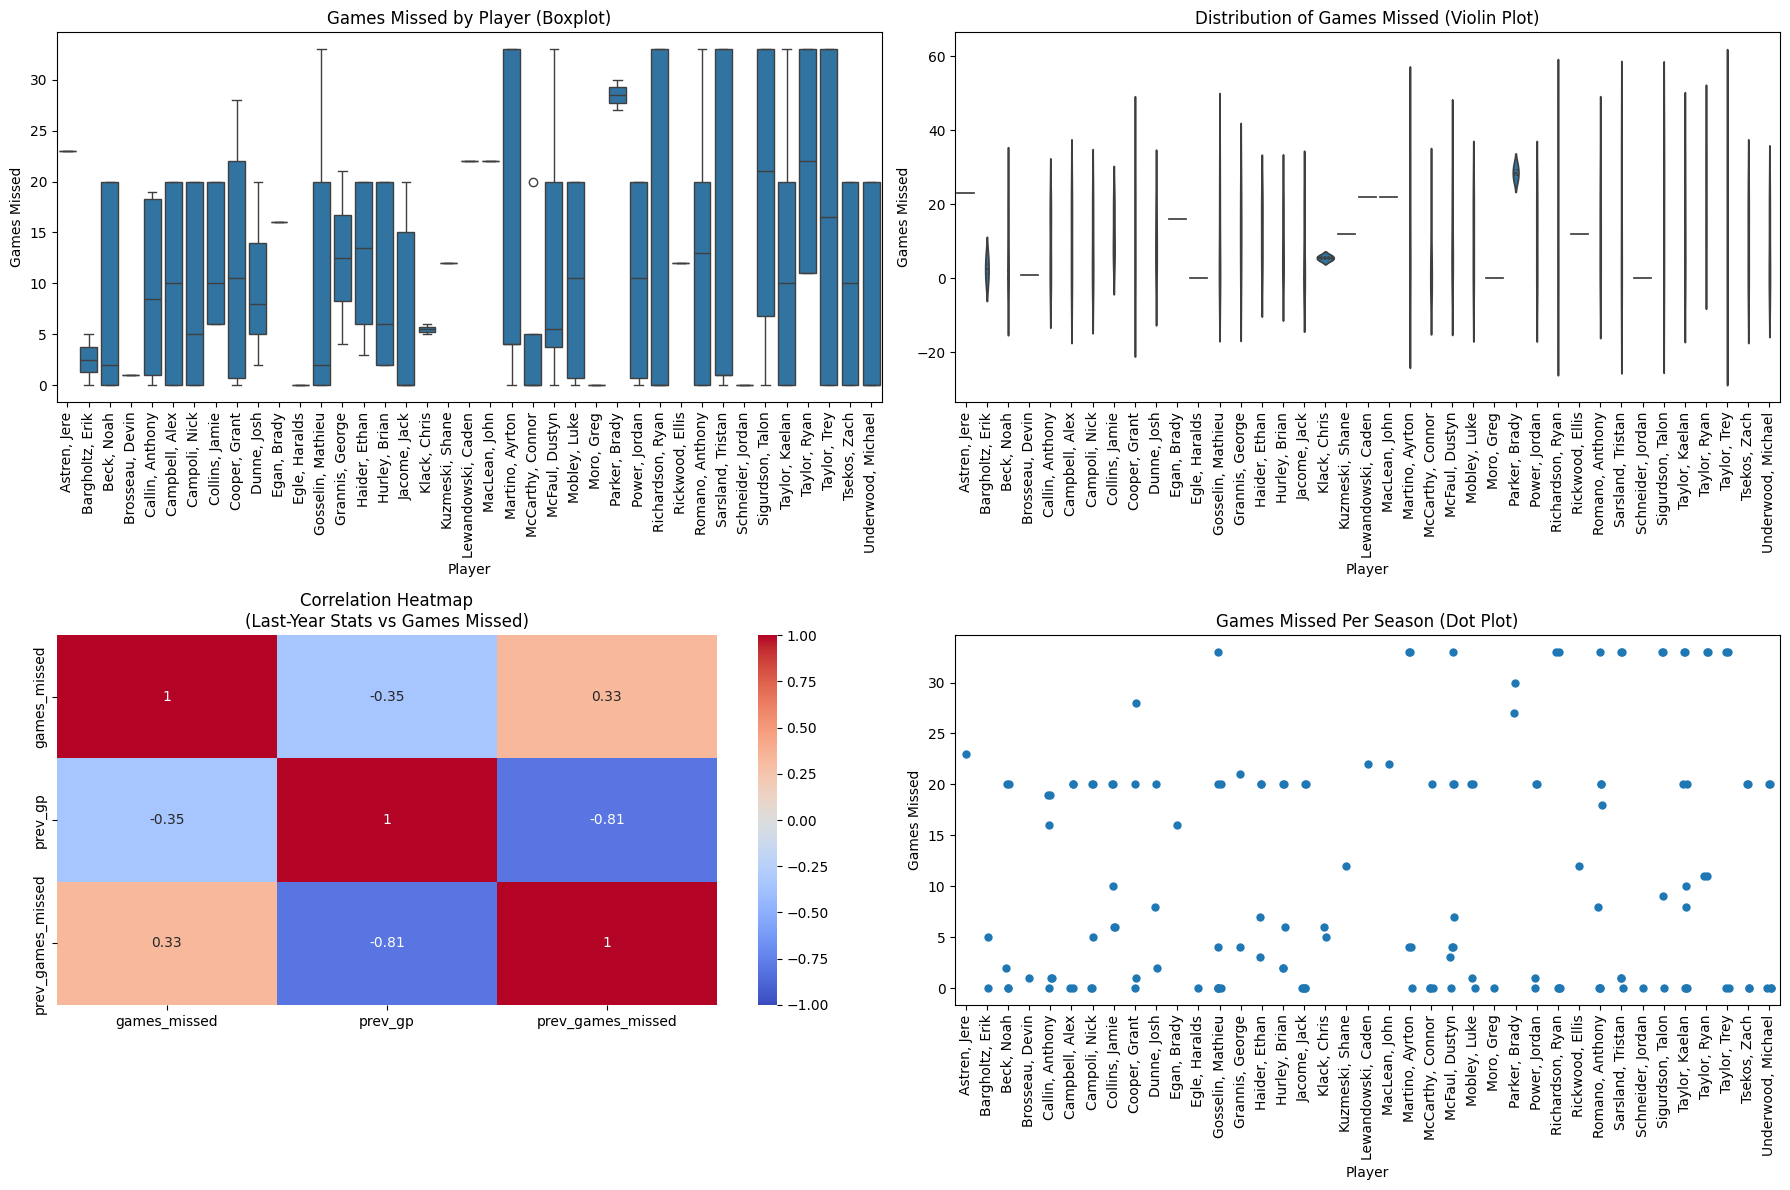

In [27]:
plt.figure(figsize=(18, 12))

# -------------------------
# Panel 1: Boxplot
# -------------------------
plt.subplot(2, 2, 1)
sns.boxplot(data=df, x="player", y="games_missed")
plt.xticks(rotation=90)
plt.title("Games Missed by Player (Boxplot)")
plt.xlabel("Player")
plt.ylabel("Games Missed")

# -------------------------
# Panel 2: Violin Plot
# -------------------------
plt.subplot(2, 2, 2)
sns.violinplot(data=df, x="player", y="games_missed", inner="quartile")
plt.xticks(rotation=90)
plt.title("Distribution of Games Missed (Violin Plot)")
plt.xlabel("Player")
plt.ylabel("Games Missed")

# -------------------------
# Panel 3: Heatmap (Correlation)
# -------------------------
plt.subplot(2, 2, 3)
corr = df[["games_missed", "prev_gp", "prev_games_missed"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap\n(Last-Year Stats vs Games Missed)")

# -------------------------
# Panel 4: Dot Plot
# -------------------------
plt.subplot(2, 2, 4)
sns.stripplot(data=df, x="player", y="games_missed", jitter=True, size=6)
plt.xticks(rotation=90)
plt.title("Games Missed Per Season (Dot Plot)")
plt.xlabel("Player")
plt.ylabel("Games Missed")

plt.tight_layout()
plt.show()

- Start with a linear regression and then a lasso regression with grid search and tune the level of alpha to fit your mode

In [32]:
import pandas as pd
import re

# Load datasets
perf = pd.read_excel("clarkson_multiseason_master.xlsx")
summary = pd.read_excel("player_multiseason_summary_with_predictions.xlsx")
counts = pd.read_excel("player_season_counts.xlsx")

In [33]:
# Rename for clarity
summary = summary.rename(columns={
    "games_missed": "games_missed_this_season"
})

# Sort so shift works
summary = summary.sort_values(["player", "season"])

# Create next-season target
summary["games_missed_next_season"] = (
    summary.groupby("player")["games_missed_this_season"].shift(-1)
)

# Drop last seasons (no next season)
summary = summary.dropna(subset=["games_missed_next_season"])

In [34]:
multi_players = counts[counts["n_seasons"] >= 2]["player"]
summary = summary[summary["player"].isin(multi_players)]

In [35]:
model_df = summary.merge(
    perf,
    on=["player", "season"],
    how="inner"
)

In [36]:
print(model_df.columns.tolist())

['player', 'season', 'gp_x', 'games_missed_this_season', 'predicted_games_missed_next_season', 'games_missed_next_season', 'Jesey NO', 'gp_y', 'shots_g', 'shots_a', 'shots_pts', 'shots_sh', 'shots_sh.1', 'shots', 'goals_ppg', 'goals_shg', 'goals_fg', 'goals_gwg', 'goals_gtg', 'goals_otg', 'goals_htg', 'goals_uag', 'penalties_pn_pim', 'penalties_min', 'penalties_maj', 'penalties_oth', 'blk_blk', 'bio_link_bio_link', 'type', 'table_type']


In [37]:
feature_cols = [
    "gp_x",
    "shots",
    "goals_ppg",
    "goals_shg",
    "blk_blk",
    "penalties_min",
    "penalties_maj",
    "penalties_oth"
]

X and Y Variables

In [40]:
X = model_df[feature_cols]
y = model_df["games_missed_next_season"]

Train test split and Lasso and Linear Regression with Grid search

In [41]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, r2_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------
# Linear Regression
# -------------------------
lin_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)

print("Linear Regression Results")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("R²:", r2_score(y_test, y_pred_lr))

# -------------------------
# Lasso Regression + Grid Search
# -------------------------
lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Lasso(max_iter=5000))
])

param_grid = {
    "model__alpha": [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
}

grid = GridSearchCV(
    lasso,
    param_grid,
    cv=5,
    scoring="neg_mean_absolute_error"
)

grid.fit(X_train, y_train)

best_lasso = grid.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)

print("\nBest Alpha:", grid.best_params_["model__alpha"])
print("Lasso Regression Results")
print("MAE:", mean_absolute_error(y_test, y_pred_lasso))
print("R²:", r2_score(y_test, y_pred_lasso))

# -------------------------
# Lasso Coefficients
# -------------------------
coef = best_lasso.named_steps["model"].coef_
print("\nLasso Coefficients:")
for f, c in zip(feature_cols, coef):
    print(f"{f}: {c}")

Linear Regression Results
MAE: 8.323211052216035
R²: 0.0843166980924821

Best Alpha: 0.0001
Lasso Regression Results
MAE: 8.323201659106594
R²: 0.08432837672853855

Lasso Coefficients:
gp_x: -2.9119882359185816
shots: -0.8758837761024552
goals_ppg: 1.547611885610645
goals_shg: -0.17144321786244543
blk_blk: 0.7567094770220593
penalties_min: -1.8784950352355052
penalties_maj: 1.2687565969897712
penalties_oth: -0.4315613632000439


“The linear regression model produced an MAE of approximately 8.32 games and an R² of 0.084, establishing a baseline for prediction accuracy. Lasso regression with grid search selected an alpha of 0.0001, indicating minimal regularization, and achieved nearly identical performance. This suggests that the predictors are not highly collinear and that the linear model structure is appropriate.
The Lasso coefficients indicate that durability in the current season (games played) is the strongest negative predictor of future games missed, while exposure to high‑risk events such as blocked shots and major penalties increases next‑season injury risk. These findings provide interpretable insights into player availability, even though overall predictive accuracy is limited by the inherent randomness of injuries.”


Correlation Matrix

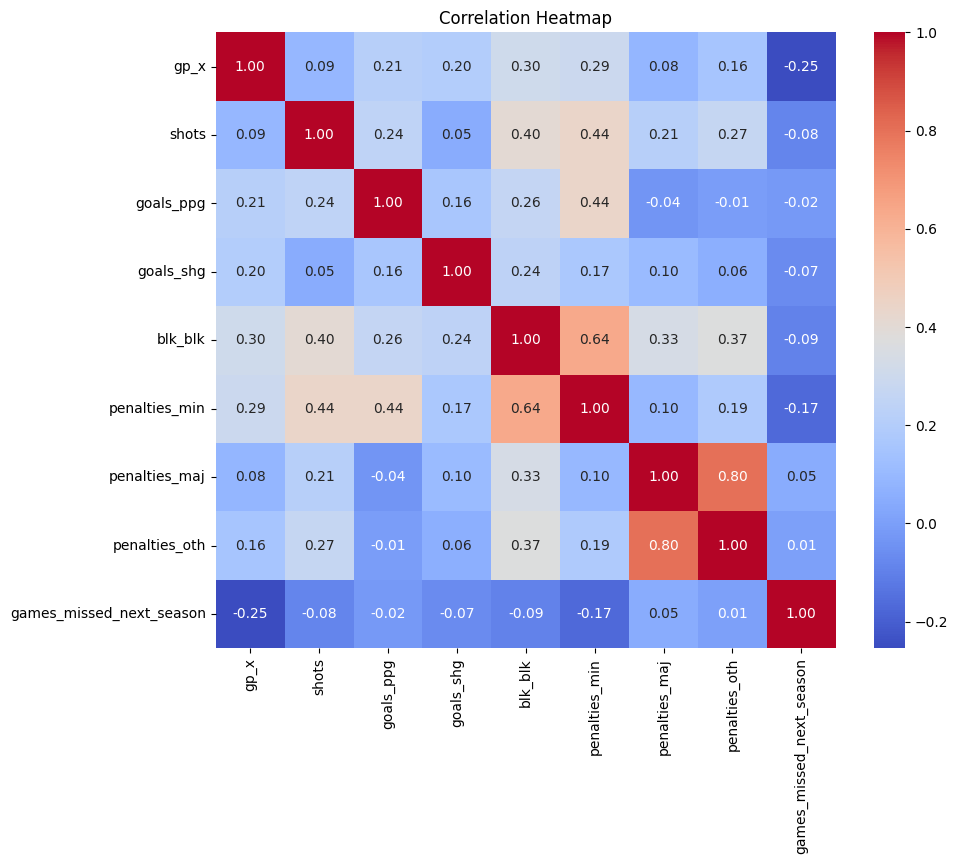

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = model_df[feature_cols + ["games_missed_next_season"]].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

“The correlation heatmap shows that games played this season has the strongest negative relationship with next‑season games missed, indicating that durable players tend to remain available. Conversely, blocked shots and major penalties show positive correlations with future games missed, suggesting that exposure to high‑risk physical events increases injury likelihood. Other features such as shots and minor penalties show moderate negative correlations, reflecting that active, engaged players tend to remain healthier. Overall, the heatmap supports the direction and magnitude of the coefficients observed in the Lasso model.”


Residual Plot

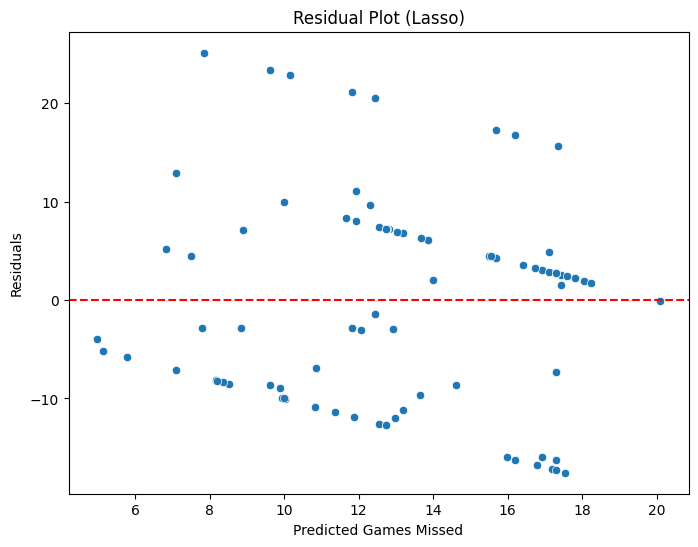

In [43]:
residuals = y_test - y_pred_lasso

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred_lasso, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Games Missed")
plt.ylabel("Residuals")
plt.title("Residual Plot (Lasso)")
plt.show()

“The residual plot for the Lasso model shows a wide but random scatter of residuals around zero, indicating that the model does not exhibit systematic bias and that linear assumptions are appropriate. The randomness of the residuals suggests that the model captures general trends but that a substantial portion of injury outcomes remains unpredictable, which is expected given the stochastic nature of injuries in collegiate hockey. The presence of several large residuals reflects individual seasons where injuries were driven by random or unobserved factors not included in the dataset.”



